# Regression models

In [39]:
import pandas as pd
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [40]:
data = pd.read_parquet('../10-data/data_final.parquet')
print(data.shape)
data.head()

(4768, 23)


,Title,Year,Country,BoxOffice,runtimeMinutes,genres,averageRating,numVotes,isRated,ForeignLanguage,...,won_Oscar,plot_sentiment_polarity,plot_sentiment_score,isPositivePlot,isFiction,Competitiveness,Cooperativeness,logBoxOffice,logRunTime,logNumVotes
tt0117365,Shadow Play,1996,"[France, United Kingdom]",16367.0,111.0,"Comedy,Romance",5.8,495,False,False,...,False,positive,0.996212,1.0,True,8.563351,9.607148,9.703022,4.709530,6.204558
tt4428762,Down by Love,2016,"[France, Belgium]",675.0,110.0,"Biography,Drama,Romance",5.9,2296,True,False,...,False,positive,0.998860,1.0,True,11.997840,10.791093,6.514713,4.700480,7.738924
tt0087399,Heavenly Bodies,1984,[Canada],1839623.0,89.0,"Drama,Romance",5.2,882,True,True,...,False,negative,0.993147,0.0,True,7.111757,8.025091,14.425071,4.488636,6.782192
tt0095303,High Season,1987,[United Kingdom],1125000.0,90.0,"Comedy,Romance",5.3,459,True,False,...,False,positive,0.989917,1.0,True,7.748589,8.581463,13.933294,4.499810,6.129050
tt2379318,Bright Days Ahead,2013,[France],21770.0,94.0,"Drama,Romance",6.3,1843,False,False,...,False,positive,0.995390,1.0,True,11.164641,12.082496,9.988288,4.543295,7.519150


## Baseline model (just linear trend)

<Axes: xlabel='Year'>

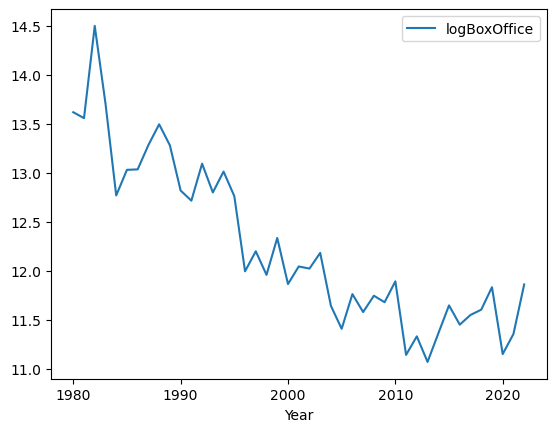

In [41]:
#Why is it reasonable?
data[['Year','logBoxOffice']].groupby('Year').mean().plot()

In [42]:
X = data[['Year']]
X = sm.add_constant(X)
y = data['logBoxOffice']

ols_0 = sm.OLS(y, X).fit()
print(ols_0.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     252.2
Date:                Thu, 28 Dec 2023   Prob (F-statistic):           2.18e-55
Time:                        22:39:45   Log-Likelihood:                -10594.
No. Observations:                4768   AIC:                         2.119e+04
Df Residuals:                    4766   BIC:                         2.121e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.2487      6.322     17.756      0.0

## Covariates model

In [43]:
X = data[['Year',
          'logRunTime',
          'isRated',
          'ForeignLanguage',
          'isCoproduction',
          'win_award',
          'nominated_award',
          'won_Oscar',
          'plot_sentiment_score',
          'isPositivePlot',
          'isFiction']].astype('float')
X = sm.add_constant(X)
y = data['logBoxOffice']

ols_1 = sm.OLS(y, X).fit()
print(ols_1.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     138.1
Date:                Thu, 28 Dec 2023   Prob (F-statistic):          3.12e-276
Time:                        22:39:45   Log-Likelihood:                -10057.
No. Observations:                4768   AIC:                         2.014e+04
Df Residuals:                    4756   BIC:                         2.021e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   60.9562 

## Full OLS model

In [44]:
X = data[['Year',
          'logRunTime',
          'isRated',
          'ForeignLanguage',
          'isCoproduction',
          'win_award',
          'nominated_award',
          'won_Oscar',
          'plot_sentiment_score',
          'isPositivePlot',
          'isFiction',
          'Cooperativeness',
          'Competitiveness',]].astype('float')
X = sm.add_constant(X)
y = data['logBoxOffice']

ols_2 = sm.OLS(y, X).fit()
print(ols_2.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     118.8
Date:                Thu, 28 Dec 2023   Prob (F-statistic):          2.24e-278
Time:                        22:39:45   Log-Likelihood:                -10047.
No. Observations:                4768   AIC:                         2.012e+04
Df Residuals:                    4754   BIC:                         2.021e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   79.7573 

## OLS models comparison

In [45]:
stargazer = Stargazer([ols_0, ols_1, ols_2])
stargazer.covariate_order(X.columns)
stargazer.custom_columns(['Trend only', 'Covariates only', 'Full model'], [1, 1, 1])
stargazer

## Multilevel model

In [46]:
import statsmodels.api as sm

# Defining the groups for varying intercepts (country and year combination)
groups = data['Country'].astype(str) + ':' + data['Year'].astype(str)

# Creating the mixed-effects model with varying intercepts for country-year combinations
hlm = sm.MixedLM(y, X, groups=groups).fit()

# Printing the summary of the model
print(hlm.summary())


              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   logBoxOffice
No. Observations:    4768      Method:               REML        
No. Groups:          2370      Scale:                3.2340      
Min. group size:     1         Log-Likelihood:       -9956.5413  
Max. group size:     29        Converged:            Yes         
Mean group size:     2.0                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025  0.975]
-----------------------------------------------------------------
const                107.826   11.349  9.501 0.000 85.582 130.070
Year                  -0.055    0.006 -9.511 0.000 -0.066  -0.043
logRunTime             2.221    0.166 13.410 0.000  1.896   2.546
isRated                1.442    0.063 22.898 0.000  1.318   1.565
ForeignLanguage       -0.222    0.083 -2.688 0.007 -0.385  -0.060
isCoproduction         0

## Model comparison

In [47]:
from stargazer.stargazer import Stargazer, LineLocation

stargazer = Stargazer([ols_0, ols_1, ols_2, hlm])
stargazer.covariate_order(X.columns)
#stargazer.custom_columns(['Trend only', 'Covariates only', 'All variables','Random Intercepts'], [1,1,1, 1])
stargazer.add_line('Model type', ['OLS', 'OLS','OLS','HLM'], LineLocation.HEADER_BOTTOM)
stargazer.show_model_numbers(True)
stargazer